pygame 2.1.2 (SDL 2.0.18, Python 3.8.8)
Hello from the pygame community. https://www.pygame.org/contribute.html
[{'box': (233, 224, 187, 187), 'emotions': {'angry': 0.0, 'disgust': 0.0, 'fear': 0.0, 'happy': 0.2, 'sad': 0.01, 'surprise': 0.0, 'neutral': 0.79}}]
[['angry', 0], ['disgust', 0], ['fear', 0], ['happy', 20], ['sad', 1], ['surprise', 0], ['neutral', 79]]


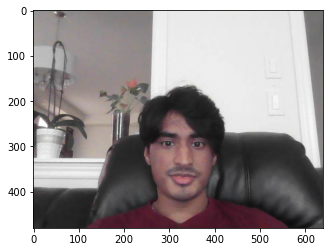

In [1]:
from tkinter import *
import pygame
import random
import time
import cv2
import tensorflow
from fer import FER
import matplotlib.pyplot as plt 
%matplotlib inline

#creating and naming window
window = Tk()
window.title("First Window")
#Changing background colour
#window.configure(background="black")

#Changing window size
width, height = window.winfo_screenwidth(), window.winfo_screenheight()
window.geometry('%dx%d+0+0' % (width,height))

#Background
bg = PhotoImage(file = "Sad_Background.gif")
label1 = Label( window, image = bg)
label1.place(x = 0, y = 0)
label1.lower()
bg_order = 0

#Title
name="Not Playing"
Label (window,text=name, bg="black",fg="white", font="none 12 bold").grid(row=3, column=3, sticky=W+E)

pygame.init()


lastmood = ""
skip = "n"
currentmood = ""
def take_pic():
    # initialize the camera
    cam = cv2.VideoCapture(0)   # 0 -> index of camera
    s, img = cam.read()
    if s:    # frame captured without any errors
        # cv2.namedWindow("cam-test",cv2.CV_WINDOW_AUTOSIZE())
        cam.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)
        cam.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
        cv2.waitKey(0)
        cv2.imwrite("emotion.jpg",img) #save image

def find_emo(lastmood):
    take_pic()
    temp_pic = plt.imread("emotion.jpg")
    emo_detector = FER(mtcnn=True)
    # Capture all the emotions on the image
    captured_emotions = emo_detector.detect_emotions(temp_pic)
    # Print all captured emotions with the image
    print(captured_emotions)
    plt.imshow(temp_pic)
    result = (emo_detector.detect_emotions(temp_pic))
    dominant_emotion, second_emotion = org_emo(result)
    play_song(dominant_emotion,second_emotion)
    
def org_emo(result):
    #Converting the info into a list
    emo_list = (str(result[0]["emotions"]).strip("[]{ }").split(","))
    split_emo_list = []
    for i in range (len(emo_list)):
        split_emo_list.append(emo_list[i].strip(" ").split(": "))
        split_emo_list[i][0] = split_emo_list[i][0].strip("'' ")
        split_emo_list[i][1] = int(float (split_emo_list[i][1])*100)
    print (split_emo_list)
    #ordering the list
    for i in range(len(split_emo_list)-1):
        current_number = split_emo_list[i+1][1]
        
        while i >= 0 and current_number > split_emo_list[i][1]:
            x = split_emo_list[i + 1]
            split_emo_list[i + 1] = split_emo_list[i]
            split_emo_list[i] = x
            i -= 1
    dominant_emotion = split_emo_list[0][0]
    second_emotion = split_emo_list[1][0]
    
    return(dominant_emotion, second_emotion)

def play_song(dominant_emotion,second_emotion):
    global lastmood
    #Determining the mood and assigning a file
    global currentmood
    if currentmood==dominant_emotion:
        currentmood = second_emotion
        filename = "%s.mp3" %second_emotion
    else:
        currentmood=dominant_emotion
        filename = "%s.mp3" %dominant_emotion
    #For automatic next song
    a = pygame.mixer.Sound(filename)
    #Getting the length of the song and converting it to milliseconds (and adding an extra second)
    length = int(a.get_length()*1000)+1
    pygame.mixer.music.load(filename)
    pygame.mixer.music.play()
    name="Playing"
    Label (window,text=name, bg="black",fg="white", font="none 12 bold").grid(row=3, column=3, sticky=W+E)
    MUSIC_END = pygame.USEREVENT+1
    SONG_END = pygame.USEREVENT
    pygame.mixer.music.set_endevent(MUSIC_END)
    #Changes track after song is done
    window.after(length, check_event)
    #We can also make it change tracks every few minutes (but we need to ensure that the music flows)

soundplay = 0
music = "PAUSE"
def playsound():
    global soundplay
    soundplay+=1
    if (soundplay==1):
        Button (window, image=pause, command=playsound, bd=0).place(relx=0.5, rely=0.5, anchor=CENTER)
        find_emo(" ")
    elif (soundplay%2==0):
        pygame.mixer.music.pause()
        Button (window, image=play, command=playsound, bd=0).place(relx=0.5, rely=0.5, anchor=CENTER)
    else:
        pygame.mixer.music.unpause()  
        Button (window, image=pause, command=playsound, bd=0).place(relx=0.5, rely=0.5, anchor=CENTER)
    #Song Length
    play_time()
def play_next():
    global lastmood
    pygame.mixer.music.fadeout
    lastmood=currentmood
    find_emo(lastmood)
def go_back():
    pygame.mixer.music.fadeout
    filename = "%s.mp3" %lastmood
    pygame.mixer.music.load(filename)
    pygame.mixer.music.play()    

def close_window():
    window.destroy()
    pygame.mixer.music.stop()
    
def check_event():
    for event in pygame.event.get():
        if event.type == MUSIC_END:
            name="Done"
            Label (window,text=name, bg="black",fg="white", font="none 12 bold").grid(row=3, column=3, sticky=W+E)
            play_next()
def play_time():
    current_time = pygame.mixer.music.get_pos()
    name="Playing"
    Label (window,text=current_time, bg="black",fg="white", font="none 12 bold").grid(row=3, column=3, sticky=W+E)
    
    
#Use this for skipping - pygame.mixer.music.fadeout
back = PhotoImage(file="Back")
Button (window, image=back, command=go_back, bg="black", bd=0).place(relx=0.35, rely=0.5, anchor=CENTER)

play = PhotoImage(file="Play")
pause = PhotoImage(file="Pause")
    
Button (window, image=play, command=playsound, bd=0).place(relx=0.5, rely=0.5, anchor=CENTER)
next = PhotoImage(file="Next")
Button (window, image=next, command=play_next, bg="black", bd=0).place(relx=0.65, rely=0.5, anchor=CENTER)

exit = PhotoImage(file="exit1.gif")
Button (window, image=exit, command=close_window).place(relx=0.98, rely=0, anchor=N)




#running the main window
window.mainloop()